In [ ]:
#download opendatasets to download dataset from kaggel with username and token API
!pip install opendatasets

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
stop = nltk.corpus.stopwords.words('english')
import zipfile
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/wanderfj/enron-spam')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: drkarimkamal
Your Kaggle Key: ··········


100%|██████████| 28.8M/28.8M [00:00<00:00, 70.1MB/s]


In [72]:
ham_data = []
spam_data = []

import os
for dirname ,dirpath , filename in os.walk('/content/enron-spam/'):

  if 'ham' in str(filename) :
    for name in filename:
      with open(dirname + '/'+name, encoding='latin1') as f:
        ham_data.append(' '.join(f.readlines()))
  elif 'spam' in str(filename) :
    for name in filename:
      with open(dirname + '/'+name,encoding='latin1') as f:
        spam_data.append(' '.join(f.readlines()))


In [ ]:
list(set(ham_data))
list(set(spam_data))

In [74]:
len(ham_data) , len(spam_data)

(16545, 17170)

In [75]:
all_data = ham_data + spam_data
labels = [0]*len(ham_data) + [1]*len(spam_data)

In [76]:
raw_df = pd.DataFrame({'email':all_data,
                       'labels': labels})
raw_df.sample(5)

,email,labels
7491,"Subject: b 2 b at enron\n tom ,\n i am sending...",0
30681,Subject: \n super cheaap softwares & shiiip to...,1
7977,Subject: re : compound model for reedy creek\n...,0
25821,Subject: wall street phenomenon reaps rewards\...,1
2351,Subject: chris calger\n his asst . called to l...,0


#plot a total counts of Spam and Ham

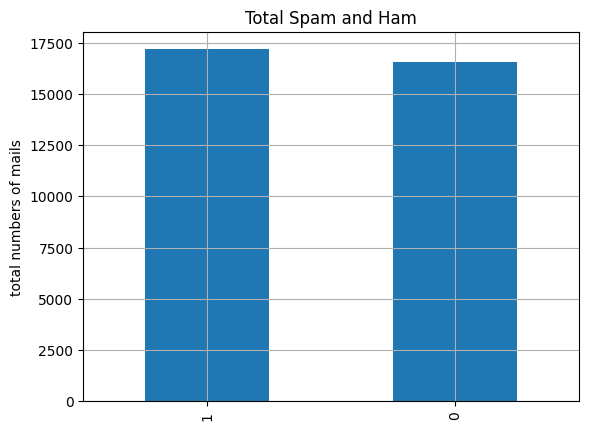

In [85]:
raw_df['labels'].value_counts().plot(kind='bar',
                                     title='Total Spam and Ham',
                                     ylabel='total numbers of mails',
                                     grid=True,);

#create a preprocess text function using `NLTK`

In [86]:

def preprocess_text(data):

  #tokenize data
  token = nltk.word_tokenize(data)
  token = [w.lower() for w in token if w.isalpha()]

  # finding uncommons
  cnt = Counter(token)
  uncommon_words = cnt.most_common()[:-int(len(cnt)*0.1):-1]

  # listing stopwords from NLTK
  stop_words = set(nltk.corpus.stopwords.words('english'))

  # removing stopwords
  token = [w for w in token if (w not in stop and w not in uncommon_words )]

  #Lemmatization
  lem = nltk.WordNetLemmatizer()
  token = [lem.lemmatize(w, pos='a') for w in token]

  return token

In [97]:
nltk_processed_df = pd.DataFrame()
nltk_processed_df['email'] = [preprocess_text(e) for e in raw_df.email]

In [98]:
nltk_processed_df['label'] = raw_df['labels']

In [103]:
#Shuffling the Data to prevent overfitting
shuffled_processed_df = nltk_processed_df.sample(frac=1)
shuffled_processed_df

,email,label
8292,"[subject, lst, chapter, training, book, george...",0
10675,"[subject, start, date, hourahead, hour, start,...",0
16885,"[subject, clear, benefits, creative, design, l...",1
934,"[subject, scheduling, meeting, sally, dolores,...",0
23920,"[subject, cancel, afresh, email, loading, perp...",1
...,...,...
18035,"[subject, perfect, visual, solution, business,...",1
4086,"[subject, lrci, board, jean, appointed, three,...",0
13488,"[subject, exxon, company, usa, global, sitara,...",0
10109,"[subject, enpwer, eol, data, eol, deals, enpow...",0


In [ ]:
#use Agg method to remove a list from email columns
shuffled_processed_df['email'] =shuffled_processed_df['email'].agg(lambda x: ', '.join(map(str, x)))
shuffled_processed_df['email']


In [121]:
#use replace method to replace comma , with a space
shuffled_processed_df['email'] = [w.replace(',',' ') for w in shuffled_processed_df['email']]
shuffled_processed_df

,email,label
8292,subject lst chapter training book george ...,0
10675,subject start date hourahead hour start ...,0
16885,subject clear benefits creative design lt...,1
934,subject scheduling meeting sally dolores ...,0
23920,subject cancel afresh email loading perpe...,1
...,...,...
18035,subject perfect visual solution business ...,1
4086,subject lrci board jean appointed three ...,0
13488,subject exxon company usa global sitara ...,0
10109,subject enpwer eol data eol deals enpowe...,0


In [153]:
#split features X and label y and convert them to numpy array
X, y = np.array(shuffled_processed_df.email), np.array(shuffled_processed_df.label).astype(np.float32)

In [133]:
# get average of each sentence to get maxlen
avg = [len(x.split()) for x in X]
max_len = round(np.mean(avg))
max_len

142

#split the data using `train_test_split` method

In [165]:


train_email , test_email , train_labels , test_labels = train_test_split(X,y,
                                                                        test_size=0.2)

#Tokenize the words using `Tokenizer` and `pad_sequences` by `Tensorflow`

In [140]:
tk = Tokenizer(num_words=1000,oov_token='<OOV>')
tk.fit_on_texts(train_email)
word_index = tk.word_index
seq = tk.texts_to_sequences(train_email)

padded_seq = pad_sequences(seq,padding='post',truncating='post',maxlen=max_len)

test_email = tk.texts_to_sequences(test_email)
test_seq = pad_sequences(test_email,padding='post',truncating='post',maxlen=max_len)

#Train the model using `Sequential API` and feed into `CNN` and `RNN`

In [141]:
model_142 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=1000,output_dim=16,input_length=max_len),

    tf.keras.layers.Conv1D(filters=64,kernel_size=5,
                           strides=3,padding='valid',activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model_142.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_142 = model_142.fit(padded_seq,
                    train_labels,
                    epochs=6,
                    validation_data=(test_seq,test_labels)
                    )

Epoch 1/6
843/843 [==============================] - 124s 136ms/step - loss: 0.1181 - accuracy: 0.9494 - val_loss: 0.0636 - val_accuracy: 0.9781
Epoch 2/6
843/843 [==============================] - 110s 130ms/step - loss: 0.0513 - accuracy: 0.9828 - val_loss: 0.0623 - val_accuracy: 0.9804
Epoch 3/6
843/843 [==============================] - 110s 131ms/step - loss: 0.0373 - accuracy: 0.9873 - val_loss: 0.0654 - val_accuracy: 0.9806
Epoch 4/6
843/843 [==============================] - 108s 128ms/step - loss: 0.0273 - accuracy: 0.9911 - val_loss: 0.0691 - val_accuracy: 0.9785
Epoch 5/6
843/843 [==============================] - 111s 131ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0723 - val_accuracy: 0.9749
Epoch 6/6
843/843 [==============================] - 108s 128ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 0.0647 - val_accuracy: 0.9767


## using `Naive Bayes` classifier and Use `TfidfVectorizer` to process Raw_df instead of use `NLTK`  

In [159]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(raw_df['email'],
                                                       raw_df['labels'],
                                                       test_size=0.2)

In [161]:
tfidf = TfidfVectorizer(stop_words='english')

x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)

In [162]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb_model = nb.fit(x_train,y_train)


In [163]:
y_pred = nb_model.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [164]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,y_pred)
acc

0.9876909387512977

## Comparing between `TensorFlow` and `Naive Bayes` for Emails Spam Detections

In [186]:
tf_acc = (np.mean(history_142.history['accuracy'])*100)

nb_acc = (acc*100)

In [180]:
print(f"Accuracy socre using TensorFlow is {(np.mean(history_142.history['accuracy'])*100):2f} %")
print(f"Accuracy socre using Naive Bayes Classifier is {(acc*100):2f} %")

Accuracy socre using TensorFlow is 98.274753 %
Accuracy socre using Naive Bayes Classifier is 98.769094 %


In [230]:
result_df = pd.DataFrame.from_dict( {'Classifier': ['TensorFlow','Naive Bayes'],
          'Accuracy': [tf_acc,nb_acc]})
result_df

,Classifier,Accuracy
0,TensorFlow,98.274753
1,Naive Bayes,98.769094


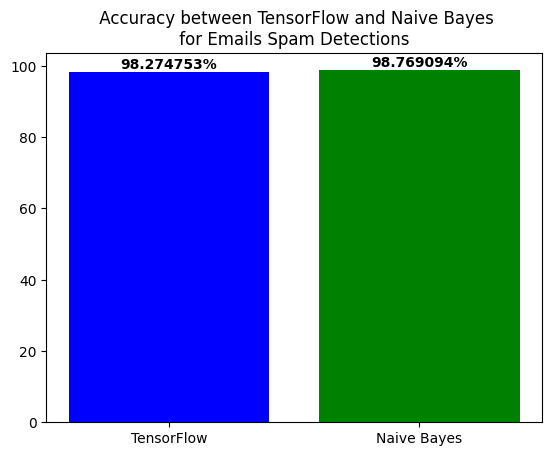

In [245]:
plt.figure()
colors_list = [ 'Blue', 'Green']
graph = plt.bar(result_df.Classifier,result_df.Accuracy,color=colors_list)
plt.title(' Accuracy between TensorFlow and Naive Bayes\n for Emails Spam Detections ')

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(f'{result_df.Accuracy[i]:4f}')+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show();